In [1]:
notebook_id = "220"

<a id="ID_top"></a>
## Adjacency matrix and network chart

This workflow takes live files and calls on functions in `script_adj_matrix_plot.py` to create adjancency matrices and network graph

#### Notebook sections:
    
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

### Packages

In [125]:
# %load s_package_import
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
import zipfile #notebook

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
#import pycountry

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
#import gme as gme

#=== distance datasets
#import wbdata


#### Import module and declare path variables
`import s_filepaths.py`

In [3]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_image = s_filepaths.path_images
path_analysis = s_filepaths.path_analysis
path_map = s_filepaths.path_map

<a id="ID_part2"></a>
### Part 2 | Load files
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

**Scope file**

In [4]:
# Load scope files
os.listdir(path_live)
file_name_scope = "125_input_scope_country.csv.gzip"
df_scope = pd.read_csv(f"{path_live}/{file_name_scope}", compression = "gzip")

list_scope_iso3 = list(df_scope.iso3_d.unique())
print(f"There are {len(list_scope_iso3)} countries in the scope file.")

There are 75 countries in the scope file.


**Route network (shape file to geopandas)**

In [5]:
# list of all files
print(os.listdir(path_map))

['ne_10m_railroads_europe_asia', 'ne_10m_railroads', '.DS_Store', '220_routes_clean.dbf', 'ne_50m_admin_europe_asia_trim', '220_routes_clean.shx', 'ne_50m_admin_europe_asia', 'ne_10m_admin_0_sovereignty', '220_routes_clean.cpg', '220_routes_clean.shp', 'test_CHN_rrd', 'ne_10m_populated_places', 'eu_asia_rail_country_joint_layer', 'ne_50m_admin_0_countries', 'test_mini', '220_routes_clean.prj', 'ne_10m_eu_asia_length', 'CH_RU_KZ_Test', 'live_dataset']


In [6]:
# Load shape file
folder = "live_dataset"
print(os.listdir(f"{path_map}/{folder}"))
file = "eurasia_simple.shp"
full_path = f"{path_map}/{folder}/{file}"

['.DS_Store', 'eurasia_simple.prj', 'eurasia_simple.qpj', 'eurasia_simple.dbf', 'eurasia_simple.shp', 'eurasia_simple.cpg', 'eurasia_simple.shx']


In [7]:
gdf_routes = gpd.read_file(full_path)
# in case there are unassigned values (except None for border crossings)
try:
    filler_term = "Cross_border"
    gdf_routes.ADMIN.fillna(filler_term,inplace = True)
    gdf_routes.ADM0_A3.fillna(filler_term,inplace = True)
except:
    pass
gdf_routes.head()

rwdb_rr_id featurecla continent         length    ADMIN ADM0_A3 CONTINENT_  \
0       22588   Railroad      Asia    1857.297457  Vietnam     VNM       Asia   
1       22591   Railroad      Asia    2851.559849  Vietnam     VNM       Asia   
2       22702   Railroad      Asia  154407.264953  Vietnam     VNM       Asia   
3       22703   Railroad      Asia   10526.730557  Vietnam     VNM       Asia   
4       22706   Railroad      Asia   91532.355892  Vietnam     VNM       Asia   

   NAME_EN                                           geometry  
0  Vietnam  LINESTRING (103.98167 22.53056, 103.96694 22.5...  
1  Vietnam  LINESTRING (103.97947 22.50575, 103.98167 22.5...  
2  Vietnam  LINESTRING (105.01750 21.54889, 103.97947 22.5...  
3  Vietnam  LINESTRING (105.80194 21.60167, 105.86917 21.5...  
4  Vietnam  LINESTRING (106.70917 21.97632, 106.29972 21.4...

In [8]:
list_route_iso3 = list(gdf_routes.ADM0_A3.unique())

**Compare scope to data**

In [9]:
list_exclude = list(set(list_route_iso3) - set(list_scope_iso3))

In [10]:
list_index_exclude = []
for entry in list_exclude:
    if entry ==filler_term:
        print(f"Skipping filler term: {filler_term}")
    else:
        
        list_index_exclude = list_index_exclude + list(gdf_routes[gdf_routes.ADM0_A3 == entry].index.values)
        
        #list_index_exclude.append(gdf_routes[gdf_routes.ADM0_A3 == entry].index.values)

Skipping filler term: Cross_border


**Exclude wrong countries for route dataframe**

In [11]:
gdf_routes_clean = gdf_routes.drop(list_index_exclude).copy()
print(gdf_routes_clean.shape)
gdf_routes_clean.head()

(20609, 9)


rwdb_rr_id featurecla continent         length    ADMIN ADM0_A3 CONTINENT_  \
0       22588   Railroad      Asia    1857.297457  Vietnam     VNM       Asia   
1       22591   Railroad      Asia    2851.559849  Vietnam     VNM       Asia   
2       22702   Railroad      Asia  154407.264953  Vietnam     VNM       Asia   
3       22703   Railroad      Asia   10526.730557  Vietnam     VNM       Asia   
4       22706   Railroad      Asia   91532.355892  Vietnam     VNM       Asia   

   NAME_EN                                           geometry  
0  Vietnam  LINESTRING (103.98167 22.53056, 103.96694 22.5...  
1  Vietnam  LINESTRING (103.97947 22.50575, 103.98167 22.5...  
2  Vietnam  LINESTRING (105.01750 21.54889, 103.97947 22.5...  
3  Vietnam  LINESTRING (105.80194 21.60167, 105.86917 21.5...  
4  Vietnam  LINESTRING (106.70917 21.97632, 106.29972 21.4...

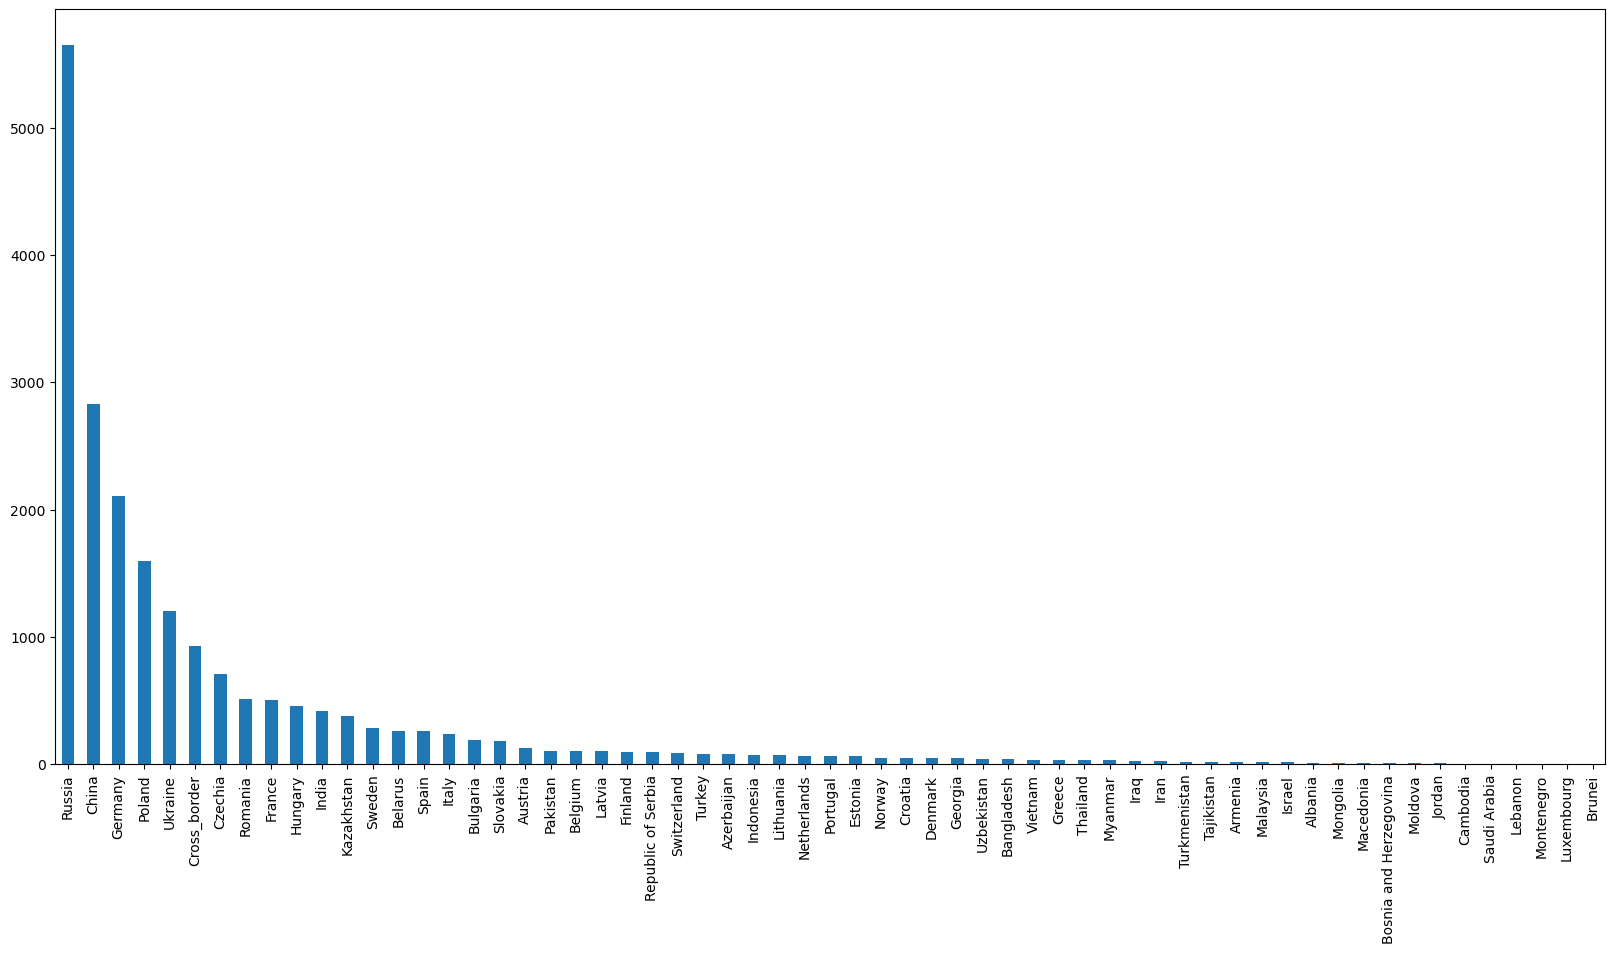

In [12]:
plt.figure(1,figsize = (20,10),dpi = 100)
gdf_routes_clean['ADMIN'].value_counts().plot(kind = 'bar')

In [13]:
# sample gdf
gdf_export = gdf_routes_clean.copy()
#gdf_export = gdf_routes_clean[gdf_routes_clean.ADMIN == "China"].copy()

In [14]:
#(122.20694416666664, 48.43333333333333)
gdf_export.head(5)

rwdb_rr_id featurecla continent         length    ADMIN ADM0_A3 CONTINENT_  \
0       22588   Railroad      Asia    1857.297457  Vietnam     VNM       Asia   
1       22591   Railroad      Asia    2851.559849  Vietnam     VNM       Asia   
2       22702   Railroad      Asia  154407.264953  Vietnam     VNM       Asia   
3       22703   Railroad      Asia   10526.730557  Vietnam     VNM       Asia   
4       22706   Railroad      Asia   91532.355892  Vietnam     VNM       Asia   

   NAME_EN                                           geometry  
0  Vietnam  LINESTRING (103.98167 22.53056, 103.96694 22.5...  
1  Vietnam  LINESTRING (103.97947 22.50575, 103.98167 22.5...  
2  Vietnam  LINESTRING (105.01750 21.54889, 103.97947 22.5...  
3  Vietnam  LINESTRING (105.80194 21.60167, 105.86917 21.5...  
4  Vietnam  LINESTRING (106.70917 21.97632, 106.29972 21.4...

In [15]:
filename = "routes_clean"
path_file_live = f"{path_map}{notebook_id}_{filename}.shp"
gdf_export.to_file(path_file_live)

**Load trimmed shape_file**

In [16]:
# load shapefile into network
route_shp_load = nx.read_shp(path_file_live,geom_attrs=True)

In [17]:
# network basics
print("Nodes: ",len(route_shp_load.nodes()))
print("Edges: ", len(route_shp_load.edges()))

Nodes:  17518
Edges:  20534


In [18]:
gdf_shp_load = gpd.read_file(path_file_live)
gdf_shp_load.head()

rwdb_rr_id featurecla continent         length    ADMIN ADM0_A3 CONTINENT_  \
0       22588   Railroad      Asia    1857.297457  Vietnam     VNM       Asia   
1       22591   Railroad      Asia    2851.559849  Vietnam     VNM       Asia   
2       22702   Railroad      Asia  154407.264953  Vietnam     VNM       Asia   
3       22703   Railroad      Asia   10526.730557  Vietnam     VNM       Asia   
4       22706   Railroad      Asia   91532.355892  Vietnam     VNM       Asia   

   NAME_EN                                           geometry  
0  Vietnam  LINESTRING (103.98167 22.53056, 103.96694 22.5...  
1  Vietnam  LINESTRING (103.97947 22.50575, 103.98167 22.5...  
2  Vietnam  LINESTRING (105.01750 21.54889, 103.97947 22.5...  
3  Vietnam  LINESTRING (105.80194 21.60167, 105.86917 21.5...  
4  Vietnam  LINESTRING (106.70917 21.97632, 106.29972 21.4...

In [19]:
# keep track of nodes and edges
# Take geometry and create 'node' columns
from shapely import wkt # in case we didn't import earlier

# series for new columns
list_node_1 = []
list_node_2 = []
list_node_key = []

for entry in gdf_shp_load.geometry:
    
    # full string for row
    full_string = wkt.dumps(entry, trim = False)
    
    # clean up string
    temp_str = full_string.replace("LINESTRING ","")
    temp_str = temp_str.replace("(","")
    temp_str = temp_str.replace(")","")
    temp_str = temp_str.replace(",","")
    #print(temp_str)
    temp_str_values = temp_str.split(" ")
    temp_node1 = (float(temp_str_values[0]),float(temp_str_values[1]))
    temp_node2 = (float(temp_str_values[2]),float(temp_str_values[3]))
    temp_node_key = (temp_node1,temp_node2)
    #print(temp_node1)
    #print(temp_node2)
    list_node_1.append(temp_node1)
    list_node_2.append(temp_node2)
    list_node_key.append(temp_node_key)
    
# add to dataframe
gdf_shp_load["node_1_position"] = list_node_1
gdf_shp_load["node_2_position"] = list_node_2
gdf_shp_load["edge_key"] = list_node_key
gdf_shp_load["node_1_id"] = "empty"
gdf_shp_load["node_2_id"] = "empty"
gdf_shp_load["edge_id"] = "empty"

In [58]:
gdf_shp_load.iloc[:,[0,1,2,3,4,5,6,7,9,10,12,13,14]].tail()

rwdb_rr_id      featurecla continent         length         ADMIN  \
20604       23514        Railroad      Asia  155087.057569  Cross_border   
20605       23622        Railroad      Asia    8384.202544  Cross_border   
20606       23630        Railroad      Asia    6642.584020  Cross_border   
20607       23637        Railroad      Asia   98042.157923  Cross_border   
20608       18479  Railroad ferry      Asia   25533.334744  Cross_border   

            ADM0_A3 CONTINENT_ NAME_EN  \
20604  Cross_border       None    None   
20605  Cross_border       None    None   
20606  Cross_border       None    None   
20607  Cross_border       None    None   
20608  Cross_border       None    None   

                                 node_1_position  \
20604   (103.84226972222221, 1.2872738888888888)   
20605  (112.72749916666666, -7.0961108333333325)   
20606  (112.72749916666666, -7.0961108333333325)   
20607           (113.493055, -7.176110833333333)   
20608     (140.35247047496802, 41.2486984752703)   

                                 node_2_position node_1_id node_2_id  \
20604     (103.0779211111111, 2.331280833333333)     17513      9176   
20605   (112.74555527777777, -7.026666944444444)     17514     17515   
20606   (112.72888888888887, -7.155833888888888)     17514     17516   
20607  (112.72749916666666, -7.0961108333333325)     17517     17514   
20608    (140.22305416666666, 41.45666666666666)     17311     17303   

              edge_id  
20604   (17513, 9176)  
20605  (17514, 17515)  
20606  (17514, 17516)  
20607  (17517, 17514)  
20608  (17311, 17303)

In [22]:
#G = nx.path_graph(3)
#>>> bb = nx.edge_betweenness_centrality(G, normalized=False)
#>>> nx.set_edge_attributes(G, 'betweenness', bb)
#>>> G[1][2]['betweenness']

In [56]:
edge_id_list = []
for element in np.arange(0,len(gdf_shp_load)):
    temp_tuple = (gdf_shp_load.iloc[element,:].node_1_id,gdf_shp_load.iloc[element,:].node_2_id)
    edge_id_list.append(temp_tuple)
    #print(temp_tuple)
gdf_shp_load["edge_id"] = edge_id_list

Visualise in keeping with original coordinates based on post [here](https://gis.stackexchange.com/questions/227909/from-shapefile-to-python-networkx)

Code:<br>
<code>
    import networkx as nx
    import matplotlib.pyplot as plt
    G=nx.read_shp('C:\Users\MyName\MyFolder\TEST.shp') 
    pos = {k: v for k,v in enumerate(G.nodes())}
    X=nx.Graph() #Empty graph
    X.add_nodes_from(pos.keys()) #Add nodes preserving coordinates
    l=[set(x) for x in G.edges()] #To speed things up in case of large objects
    edg=[tuple(k for k,v in pos.items() if v in sl) for sl in l] #Map the G.edges start and endpoints onto pos
    nx.draw_networkx_nodes(X,pos,node_size=100,node_color='r')
    X.add_edges_from(edg)
    nx.draw_networkx_edges(X,pos)
    plt.xlim(450000, 470000) #This changes and is problem specific
    plt.ylim(430000, 450000) #This changes and is problem specific
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('From shapefiles to NetworkX')
</code>




In [27]:
time_start = time.time() # timer start

positions = {}

for index,node_pos in enumerate(route_shp_load.nodes()):
    
    try:
        # filter data frame to get list of indeces for | node 1
        temp_node_1_index = list(gdf_shp_load[gdf_shp_load.node_1_position == node_pos].index)
        # assign position id value to new node_id column | node 1
        gdf_shp_load.iloc[temp_node_1_index,-3] = index
    except:
        pass
        
    # repeate above for node 2
    try:
        temp_node_2_index = list(gdf_shp_load[gdf_shp_load.node_2_position == node_pos].index)
        gdf_shp_load.iloc[temp_node_2_index,-2] = index
    except:
        pass
    
    # for testing only (hard stop)
    #if index == 10:
     #   break
    #else:
     #   pass
    
    
    # here is where we can change the names!
    positions.update({index : node_pos})
    
time_end = time.time()
duration = time_end - time_start
print(f"This task took: {duration/60}")

This task took: 2.3403907140096027


In [36]:
# works for majority (Save 83 or so problematic ones)
#gdf_shp_load.head(10)

In [35]:
# export to shp to see
gdf_error_nodes =gdf_shp_load[(gdf_shp_load.node_1_id == "empty") | (gdf_shp_load.node_2_id == "empty")].copy()
gdf_error_nodes.drop(["node_1_position","node_2_position","edge_key","edge_id"],axis = 1,inplace =True)
filename = "routes_diagnose"
path_file_live = f"{path_map}{notebook_id}_{filename}.shp"
gdf_error_nodes.to_file(path_file_live)

In [38]:
# get positions
#positions = {k: v for k,v in enumerate(route_shp_load.nodes())}
#positions[98]

**Set up clean/positioned network**

In [40]:
# empty graph
new_graph = nx.Graph()

# add nodes based on the above positions
new_graph.add_nodes_from(positions.keys())

In [ ]:
# chance to relable the nodes
#new_graph.nodes()

In [43]:
# add edges
list_of_edges =[x for x in route_shp_load.edges()] # amended version without the set to see what happens

In [44]:
list_of_edges[0] #== (gdf_shp_load.iloc[0,:].node_1_position,gdf_shp_load.iloc[0,:].node_2_position)

((103.98166666666665, 22.530555277777776),
 (103.96694444444444, 22.535000555555552))

Create named list of edges

In [47]:
time_start = time.time()
# translate list of edges into the node names to generate a adjecency list
list_of_named_edges = []

for i,edge in enumerate(list_of_edges):
    temp_tuple = ["",""]
        
    for index,tuple_coordinate in enumerate(edge):    
        
        for name,pos_coord in positions.items():
            
            if tuple_coordinate == pos_coord:
                temp_tuple[index] = name
          
    # possibility to drop an edge if it is equal to itself (circlular reference)
    assign = (temp_tuple[0],temp_tuple[1])
    list_of_named_edges.append(assign)
    #print(i,edge)
    #df_temp_index = gdf_shp_load[gdf_shp_load.edge_key == edge].edge_id.index[0]
    #gdf_shp_load.loc[df_temp_index,"edge_id"] = str(assign)

time_end = time.time()
duration = time_end - time_start
print(f"\tThis task took: {duration/60}")

	This task took: 3.1105728149414062


In [49]:
list_of_edges[0:5]

[((103.98166666666665, 22.530555277777776),
  (103.96694444444444, 22.535000555555552)),
 ((103.97946944444443, 22.50575), (103.98166666666665, 22.530555277777776)),
 ((105.01749972222221, 21.54888972222222), (103.97946944444443, 22.50575)),
 ((105.80194472222222, 21.601666388888887),
  (105.86916722222222, 21.532500277777775)),
 ((105.86916722222222, 21.532500277777775), (106.29972, 21.421944444444442))]

In [59]:
list_of_named_edges[0:5]

[(0, 1), (2, 0), (3, 2), (4, 5), (5, 7)]

**Set attributes**

In [113]:
dict_country = {}
dict_length = {}
for element in np.arange(0,len(gdf_shp_load)):
    temp_row = gdf_shp_load.iloc[element,:]
    temp_edge_id = temp_row.edge_id
    #print(element,temp_edge_id)
    
    temp_country = temp_row.ADM0_A3
    temp_length = temp_row.length
    if "empty" in temp_edge_id:
        #print(element,"skipped")
        pass
    else:
        dict_country.update({temp_edge_id : temp_country})
        dict_length.update({temp_edge_id : temp_length})

In [114]:
# add edges to our new graph
new_graph.add_edges_from(list_of_named_edges)

In [117]:
# add attributes
nx.set_edge_attributes(new_graph,dict_country,"iso3")
nx.set_edge_attributes(new_graph,dict_length,"length")

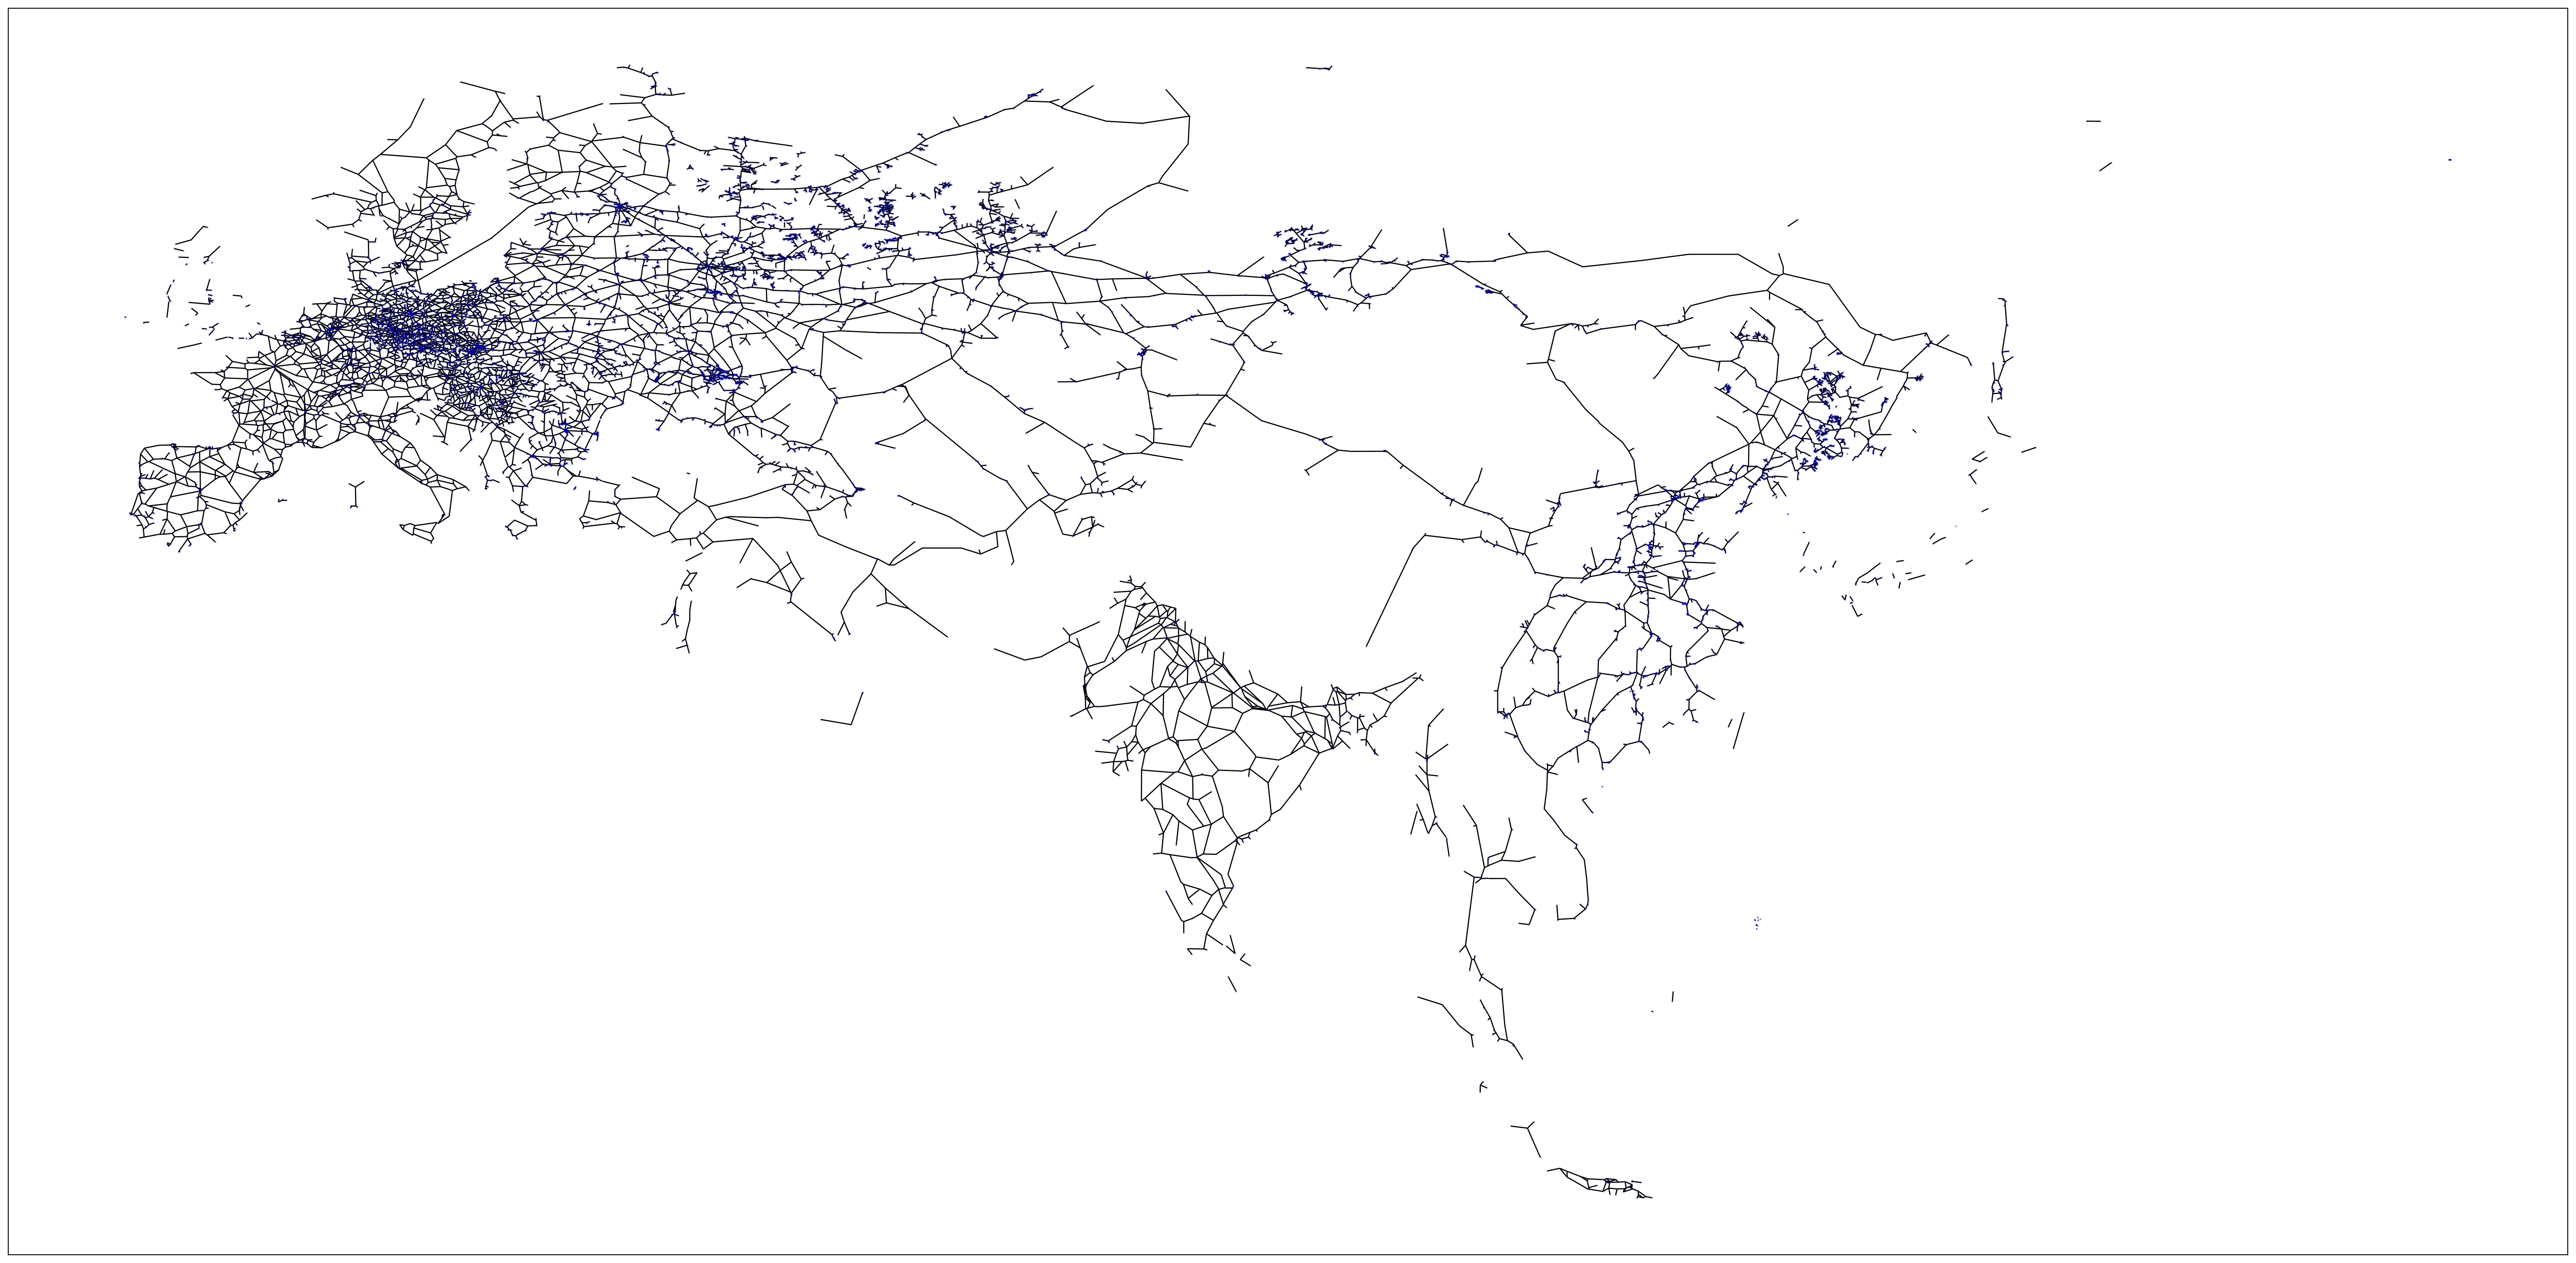

In [118]:
# Visualise
plt.figure(1,figsize = (40,20),dpi = 200)
nx.draw_networkx_nodes(new_graph,positions,node_size=1,node_color='b',alpha = 0.1)
nx.draw_networkx_edges(new_graph,positions)

In [119]:
# diagnostic for positions of specific coordinates
search_item = (122.20694416666664, 48.43333333333333)

for index,entry in enumerate(list_of_edges):
    for value in entry:
        if value[0] == search_item[0]:
            print(index)

16469
16470
16470
16541


**Betweeness centrality**

In [ ]:
# betweeness
time_start = time.time()
betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(new_graph)
time_end = time.time()
duration = time_end - time_start
print(f"This task took: {duration/60}")

In [122]:
# Assign new names to list
list_of_distances = ["length","dummy"]

# for every distance measure run the test
df_betweeness = pd.DataFrame(index = np.arange(0,len(new_graph)))

for distance in list_of_distances:
    time_start = time.time()
    print(f"Working on distance: {distance}")
    betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(new_graph,weight = distance)
    temp_df = pd.DataFrame.from_dict(betweeness_centrality,orient = "index",columns=[distance]).reset_index()
    temp_df.columns = [f"Country ({distance})",distance]
    temp_df = temp_df.sort_values(by = distance, ascending = False).reset_index(drop = True).copy()
    
    df_betweeness = df_betweeness.merge(temp_df,how="left",left_index = True,right_index = True).copy()
    time_end = time.time()
    duration = time_end - time_start
    print(f"\tThis task took: {duration/60}")

Working on distance: length
	This task took: 435.84186636606853
Working on distance: dummy
	This task took: 69.63311166763306


In [127]:
betweenness_name = "route_between"

s_file_export.f_df_export(df_betweeness,betweenness_name,p_file_id = f"{notebook_id}_",p_loc2 = path_analysis,
                          p_loc2_pre = "analysis_"
                         )

Export | ../Data/1_raw_processed_backup/220_store_route_between_20200816_1201.csv | COMPLETE
COPY   | ../Data/3_analysis/220_analysis_route_between.csv.gzip | COMPLETE


In [128]:
gdf_shp_load.head()

rwdb_rr_id featurecla continent         length    ADMIN ADM0_A3 CONTINENT_  \
0       22588   Railroad      Asia    1857.297457  Vietnam     VNM       Asia   
1       22591   Railroad      Asia    2851.559849  Vietnam     VNM       Asia   
2       22702   Railroad      Asia  154407.264953  Vietnam     VNM       Asia   
3       22703   Railroad      Asia   10526.730557  Vietnam     VNM       Asia   
4       22706   Railroad      Asia   91532.355892  Vietnam     VNM       Asia   

   NAME_EN                                           geometry  \
0  Vietnam  LINESTRING (103.98167 22.53056, 103.96694 22.5...   
1  Vietnam  LINESTRING (103.97947 22.50575, 103.98167 22.5...   
2  Vietnam  LINESTRING (105.01750 21.54889, 103.97947 22.5...   
3  Vietnam  LINESTRING (105.80194 21.60167, 105.86917 21.5...   
4  Vietnam  LINESTRING (106.70917 21.97632, 106.29972 21.4...   

                            node_1_position  \
0  (103.98166666666665, 22.530555277777776)   
1            (103.97946944444443, 22.50575)   
2   (105.01749972222221, 21.54888972222222)   
3  (105.80194472222222, 21.601666388888887)   
4  (106.70917305555555, 21.976316388888886)   

                            node_2_position  \
0  (103.96694444444444, 22.535000555555552)   
1  (103.98166666666665, 22.530555277777776)   
2            (103.97946944444443, 22.50575)   
3  (105.86916722222222, 21.532500277777775)   
4           (106.29972, 21.421944444444442)   

                                            edge_key node_1_id node_2_id  \
0  ((103.98166666666665, 22.530555277777776), (10...         0         1   
1  ((103.97946944444443, 22.50575), (103.98166666...         2         0   
2  ((105.01749972222221, 21.54888972222222), (103...         3         2   
3  ((105.80194472222222, 21.601666388888887), (10...         4         5   
4  ((106.70917305555555, 21.976316388888886), (10...         6         7   

  edge_id  
0  (0, 1)  
1  (2, 0)  
2  (3, 2)  
3  (4, 5)  
4  (6, 7)

In [159]:
top_20_nodes = list(df_betweeness.head(500).loc[:,"Country (length)"])

In [160]:
#top_20_nodes
all_node1 = set(gdf_shp_load.node_1_id.unique())
all_node2 = set(top_20_nodes)-all_node1
all_node1 = set(top_20_nodes) - all_node2

In [161]:
temp_df = gdf_shp_load.set_index("node_1_id",drop = False).copy()

In [162]:
temp_df.loc[list(all_node1),:].ADMIN.value_counts()

#gdf_shp_load[gdf_shp_load.node_1_id ]

Russia          406
Poland          119
China            85
Kazakhstan       60
Germany          31
Belarus          27
Cross_border     16
Lithuania        12
Ukraine          12
Latvia            7
Name: ADMIN, dtype: int64

**Centrality**

In [163]:
centrality = nx.algorithms.centrality.degree_centrality(new_graph)

In [164]:
import collections

In [165]:
outdeg = new_graph.degree()
to_highlight = [n[0] for n in outdeg if outdeg[n[0]] >= 5]
normal = [n[0] for n in outdeg if outdeg[n[0]] < 5]

In [166]:
print(to_highlight)

[162, 1439, 1515, 1634, 3255, 4452, 4557, 4638, 4704, 5224, 5319, 5470, 6073, 9412, 9473, 10802, 10905, 10995, 11061, 12959, 14887]


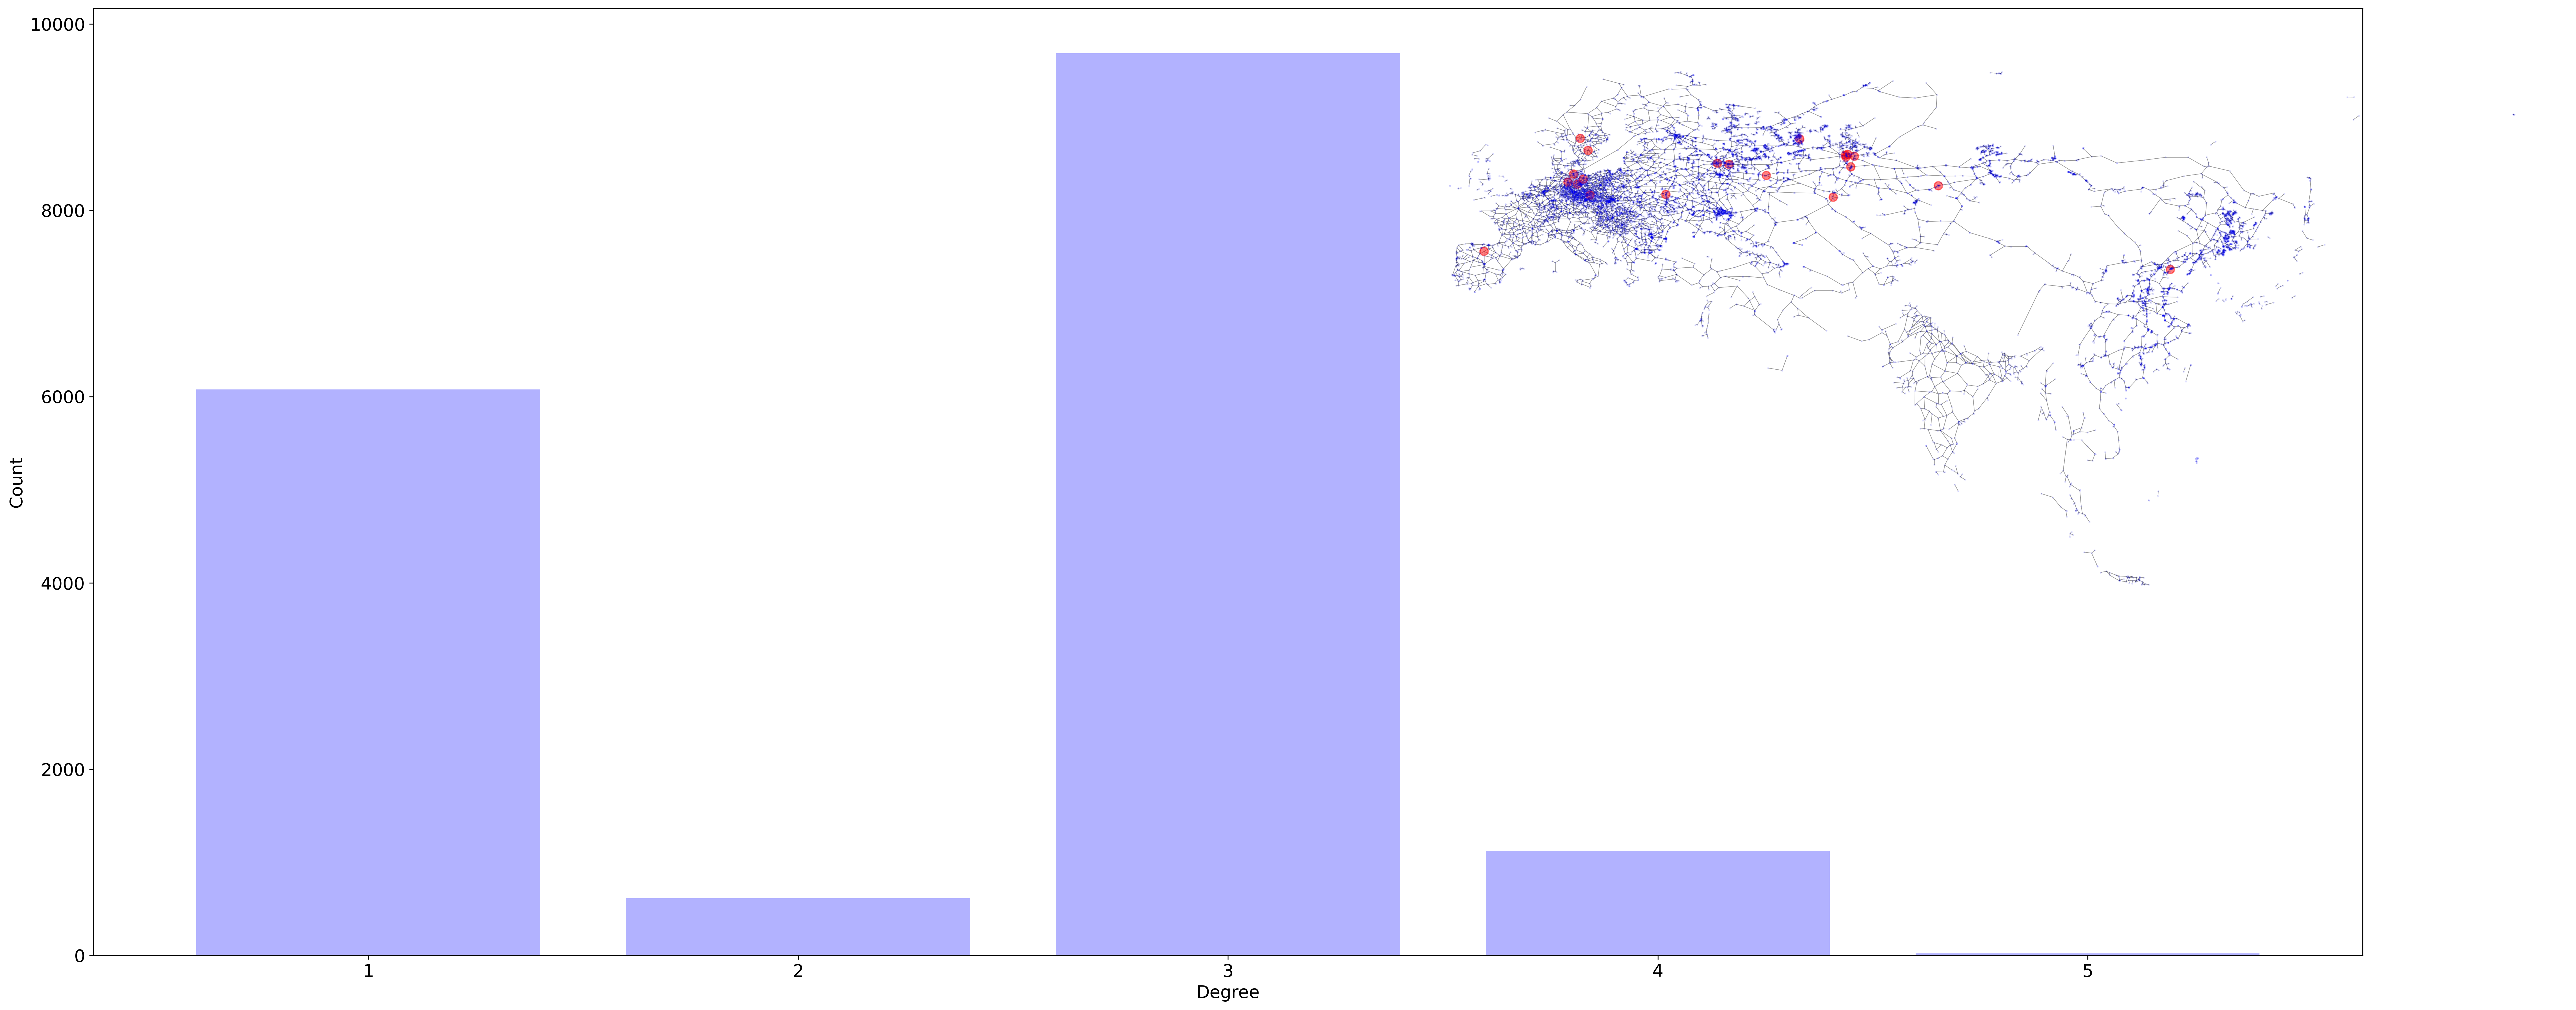

In [167]:
degree_sequence = sorted([d for n, d in new_graph.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (35,15),dpi = 300)
plt.bar(deg, cnt, width=0.80, color='b',alpha = 0.3)

#plt.title("Degree Histogram")
plt.ylabel("Count",fontsize = 15)
plt.xlabel("Degree", fontsize = 15)
ax.set_xticks([d + 0 for d in deg])
ax.set_xticklabels(deg,fontsize = 15)
ax.tick_params(axis='y', labelsize= 15) 

# draw graph in inset
plt.axes([0.57, 0.4, 0.4, 0.45])
Gcc = new_graph.subgraph(sorted(nx.connected_components(new_graph), key=len, reverse=True)[0])
#pos = nx.spring_layout(new_graph,pos = positions)
plt.axis('off')
nx.draw_networkx_nodes(to_highlight, positions, node_size=50,node_color = "red",alpha = 0.5,dpi=300)
#nx.draw_networkx_labels(to_highlight, pos, labels= to_highlight )
nx.draw_networkx_nodes(normal, positions, node_size=0.5,node_color = "blue",alpha = 0.1,dpi=300)
nx.draw_networkx_edges(new_graph, positions, alpha=0.4,dpi=150,width = 0.5)

plot_name = "country_degree_hist.png"
#plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")
plt.show()

**Short path test** [move to analysis section]

In [169]:
edge_start = 21446
edge_end = 20676

gdf_shp_load[(gdf_shp_load.rwdb_rr_id == 21446) | (gdf_shp_load.rwdb_rr_id == 20676)]

rwdb_rr_id featurecla continent         length         ADMIN  \
18308       21446   Railroad      Asia   60478.263220         China   
20493       20676   Railroad      Asia  151366.066545  Cross_border   

            ADM0_A3 CONTINENT_                     NAME_EN  \
18308           CHN       Asia  People's Republic of China   
20493  Cross_border       None                        None   

                                                geometry  \
18308  LINESTRING (121.27889 31.03611, 120.75944 30.7...   
20493  LINESTRING (117.94528 34.31194, 119.45806 34.7...   

                                node_1_position  \
18308  (121.27888833333331, 31.036111944444443)   
20493   (117.94527805555556, 34.31194472222222)   

                                node_2_position  \
18308  (120.75944472222223, 30.759721111111112)   
20493   (119.45805527777779, 34.72611166666667)   

                                                edge_key node_1_id node_2_id  \
18308  ((121.27888833333331, 31.036111944444443), (12...     15715     15741   
20493  ((117.94527805555556, 34.31194472222222), (119...     15466     17409   

              edge_id  
18308  (15715, 15741)  
20493  (15466, 17409)

In [172]:
node_start = 15715
node_end = 7304

In [173]:
list_of_distances = ["length","dummy"]

for entry in list_of_distances:
    print(f"Shortest path ({entry})| {path_start}=>{path_end} | \n\t{nx.nx.single_source_dijkstra(new_graph,node_start,node_end,weight =entry)}")

Shortest path (length)| 21446=>20676 | 
	(10188089.05576576, [15715, 15713, 15708, 15692, 15633, 15632, 15636, 15639, 15646, 15647, 15651, 15642, 15631, 15622, 15620, 15612, 15586, 15569, 15566, 15563, 15562, 15558, 15556, 15553, 15527, 15513, 15483, 15477, 15472, 15468, 15467, 15446, 15391, 15394, 15398, 15425, 15420, 15416, 15414, 15408, 15400, 15401, 15407, 15423, 15419, 15410, 15411, 15413, 15406, 15432, 15448, 15470, 15469, 15463, 15457, 15431, 15409, 15289, 15259, 15260, 15255, 15250, 15242, 15058, 15010, 14988, 14975, 14915, 14836, 14786, 14749, 14538, 14376, 14372, 14374, 14352, 14317, 14315, 14297, 14293, 14279, 14276, 14223, 14224, 9648, 9621, 9616, 9614, 9623, 9619, 9607, 9586, 9565, 9557, 9552, 9540, 9536, 9526, 9525, 9524, 9520, 9514, 9510, 9469, 9462, 9461, 9458, 9441, 9438, 9439, 9432, 9430, 9423, 9392, 9386, 9385, 9382, 9381, 9380, 6337, 6339, 6333, 6332, 6223, 6222, 6218, 6178, 6026, 6027, 6035, 5998, 5766, 5706, 5689, 5724, 5973, 6265, 6290, 6279, 6341, 6346, 6342, 63

Load data directly from compressed file to avoid GitHub issues with storage

In [ ]:
# Load data
df_network_country = pd.read_csv(f"{path_live}{filename}",compression= "gzip")
df_network_country.head()

### Prepare data for visualisation

In [ ]:
# returns adjancecy matrix [position 0] and list of pairs [1]
array_adjacency = s_adj_matrix_plot.f_adj_matrix(df_network_country,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")

In [ ]:
# update formula to dynamically add network characteristics
list_of_distances = ["distance","institutional_distance","economic_distance","di_min_max","de_min_max"]
#list_of_distances_to_call = ["DD_dummy","DW","DE","DE_minmax","DI","DI_minmax"]

In [ ]:
# distance attributes in edges: dw, di, de, di_min_max, de_min_max
list_of_distances_to_call = ["length","dw","de","de_min_max","di","di_min_max"]

In [ ]:
network_country = s_adj_matrix_plot.f_graph(array_adjacency[1],df_network_country,p_group_of_countries = list(df_network_country.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, 
                        p_weight = "de_min_max",p_visualise = True,p_edge_traits_columns=list_of_distances,
                                            p_fig_size = (60,60),p_dpi = 150,p_node_size = 500, p_node_font = 30
                                           )

In [ ]:
# Code to see all edges and attributes
#nx.get_edge_attributes(network_country,"di_min_max")
#network_country.edges.data()

**Test 2 | Shortest path test**

In [ ]:
# Path test
path_start = "China"
path_end = "Germany"

print(list_of_distances_to_call)

In [ ]:
for entry in list_of_distances_to_call:
    
    print(f"Shortest path ({entry})| {path_start}=>{path_end} | \n\t{nx.nx.single_source_dijkstra(network_country,path_start,path_end,weight =entry)}")
    print("")

**Test 3 | Betweeness centrality**

In [ ]:
# betweeness
betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(network_country)

In [ ]:
# Assign new names to list
list_of_distances = ["length","dw","de","de_min_max","di","di_min_max"]

# for every distance measure run the test
df_betweeness = pd.DataFrame(index = np.arange(0,len(betweeness_centrality)))

for distance in list_of_distances:
    print(f"Working on distance: {distance}")
    betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(network_country,weight = distance, k = len(betweeness_centrality))
    temp_df = pd.DataFrame.from_dict(betweeness_centrality,orient = "index",columns=[distance]).reset_index()
    temp_df.columns = [f"Country ({distance})",distance]
    temp_df = temp_df.sort_values(by = distance, ascending = False).reset_index(drop = True).copy()
    
    df_betweeness = df_betweeness.merge(temp_df,how="left",left_index = True,right_index = True).copy()
    
    

In [ ]:
df_betweeness.head(10)

In [ ]:
# Export .csv
bc_filename = "betweeness_centrality"
s_file_export.f_df_export(df_betweeness,bc_filename,p_compression=None,p_loc2=path_analysis,p_loc2_pre="analysis_",p_file_id=f"{notebook_id}_")

In [ ]:
#df_betweeness.tail(35)

**Test 1 | Centrality**

In [ ]:
# Centrality
centrality = nx.algorithms.centrality.degree_centrality(network_country)

**Figure 10 | Country degree histogram**

#### Degree distribution
Code from [here](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html) only amedment done is remaping variables and some stylistic changes.

In [ ]:
import collections

In [ ]:
outdeg = network_country.degree()
to_highlight = [n[0] for n in outdeg if outdeg[n[0]] >= 8]
normal = [n[0] for n in outdeg if outdeg[n[0]] < 8]

In [ ]:
to_highlight

In [ ]:
degree_sequence = sorted([d for n, d in network_country.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (25,10),dpi = 150)
plt.bar(deg, cnt, width=0.80, color='b',alpha = 0.3)

#plt.title("Degree Histogram")
plt.ylabel("Count",fontsize = 15)
plt.xlabel("Degree", fontsize = 15)
ax.set_xticks([d + 0 for d in deg])
ax.set_xticklabels(deg,fontsize = 15)
ax.tick_params(axis='y', labelsize= 15) 

# draw graph in inset
plt.axes([0.5, 0.4, 0.4, 0.45])
Gcc = network_country.subgraph(sorted(nx.connected_components(network_country), key=len, reverse=True)[0])
pos = nx.spring_layout(network_country)
plt.axis('off')
nx.draw_networkx_nodes(to_highlight, pos, node_size=50,node_color = "red",alpha = 0.5,dpi=150)
#nx.draw_networkx_labels(to_highlight, pos, labels= to_highlight )
nx.draw_networkx_nodes(normal, pos, node_size=20,node_color = "blue",alpha = 0.3,dpi=150)
nx.draw_networkx_edges(network_country, pos, alpha=0.4,dpi=150)

plot_name = "country_degree_hist.png"
#plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")
plt.show()

<a id="ID_part3"></a>
### Part 3 | Proper visualisation
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [ ]:
break

In [ ]:
plt.figure(1,figsize = (60,60),dpi = 150)
nx.draw_spring(network_country, with_labels = True, font_weight = "light",node_size=500,font_size=25, seed = 1)
plt.show()